## Importing libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import hvplot.dask

import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.utils.class_weight import compute_sample_weight, compute_class_weight
from sklearn import metrics
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


import scipy

import dask
import dask.dataframe as dd
import dask.array as da
from dask.distributed import Client, SSHCluster
import dask.distributed

import dask_ml
from dask_ml.model_selection import train_test_split
from dask_ml.preprocessing import LabelEncoder

import xgboost as xgb

import mpl_scatter_density
import matplotlib.colors as colors

import csv
from scipy.spatial.distance import jensenshannon as JS

## Setting up the cluster

In [2]:
#cluster.close()

In [3]:
cluster = SSHCluster(["bhbh-1", "bhbh-1", "bhbh-2", "bhbh-3", "bhbh-4", "bhbh-5"],
                    connect_options={"client_keys": "/home/ubuntu/private/tbertola_key.pem"},
                    worker_options={"n_workers": 4,
                                    "nthreads": 1}, # because each bhbh-* has 4 cores
                    scheduler_options={"port": 8786, "dashboard_address": ":8787"}
                    )

2023-07-02 19:04:19,010 - distributed.deploy.ssh - INFO - 2023-07-02 19:04:19,009 - distributed.scheduler - INFO - State start
2023-07-02 19:04:19,013 - distributed.deploy.ssh - INFO - 2023-07-02 19:04:19,011 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-e1e1b091', purging
2023-07-02 19:04:19,023 - distributed.deploy.ssh - INFO - 2023-07-02 19:04:19,022 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-znfwxqjy', purging
2023-07-02 19:04:19,024 - distributed.deploy.ssh - INFO - 2023-07-02 19:04:19,024 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-5qsgp0g_', purging
2023-07-02 19:04:19,026 - distributed.deploy.ssh - INFO - 2023-07-02 19:04:19,026 - distributed.diskutils - INFO - Found stale lock file and directory '/tmp/dask-scratch-space/worker-ommiuoj2', purging
2023-07-02 19:04:19,040 - distributed.deploy.ssh - INFO - 2023-07

In [4]:
client=Client(cluster)

/home/ubuntu/miniconda3/lib/python3.10/site-packages/distributed/client.py:1388: VersionMismatchWarning: Mismatched versions found

+---------+--------+-----------+------------------+
| Package | Client | Scheduler | Workers          |
+---------+--------+-----------+------------------+
| tornado | 6.3.2  | 6.3.2     | {'6.3.2', '6.2'} |
+---------+--------+-----------+------------------+
  warnings.warn(version_module.VersionMismatchWarning(msg[0]["warning"]))


In [5]:
client

<Client: 'tcp://10.67.22.140:8786' processes=20 threads=20, memory=38.78 GiB>

## Data

## Discretizing and introducing labels

# Reading from disk 

In [6]:
n_bins = 100
bhbh_train = dd.read_parquet('/home/ubuntu/train_chirp/*')
bhbh_test = dd.read_parquet('/home/ubuntu/test_chirp/*')

len_train = len(bhbh_train)
len_test = len(bhbh_train)

#selecting no-kick2
bhbh_train = bhbh_train[bhbh_train.No_Kick ==2]
bhbh_test = bhbh_test[bhbh_test.No_Kick ==2]

print(f'% of train with No Kick: {len(bhbh_train)/len_train:.2f}')
print(f'% of test with No Kick: {len(bhbh_test)/len_test:.2f}')

% of train with No Kick: 0.62
% of test with No Kick: 0.27


In [7]:
test = bhbh_train['label'].values.compute()
values, counts = np.unique(test, return_counts=True)
for v, c in zip(values, counts):
    print(v,c)

0.0 10
1.0 165
2.0 1238
3.0 62976
4.0 54799
5.0 4599
6.0 3424
7.0 20890
8.0 28541
9.0 22838
10.0 16717
11.0 12336
12.0 23835
13.0 39645
14.0 49566
15.0 56305
16.0 63759
17.0 72234
18.0 72952
19.0 69926
20.0 67523
21.0 68257
22.0 70386
23.0 69428
24.0 70899
25.0 65463
26.0 65466
27.0 70732
28.0 65198
29.0 56537
30.0 49673
31.0 45058
32.0 45515
33.0 56395
34.0 74503
35.0 64244
36.0 54170
37.0 50458
38.0 49265
39.0 48525
40.0 48712
41.0 49796
42.0 56461
43.0 58610
44.0 58924
45.0 59207
46.0 60394
47.0 59182
48.0 59163
49.0 59088
50.0 57736
51.0 55671
52.0 55281
53.0 53710
54.0 52836
55.0 51085
56.0 49972
57.0 47007
58.0 44301
59.0 41189
60.0 37066
61.0 32336
62.0 28412
63.0 24591
64.0 22036
65.0 19851
66.0 17702
67.0 16513
68.0 15203
69.0 13636
70.0 12454
71.0 11107
72.0 9804
73.0 8464
74.0 7316
75.0 6290
76.0 5700
77.0 4620
78.0 3802
79.0 3404
80.0 2599
81.0 2215
82.0 1610
83.0 1378
84.0 980
85.0 641
86.0 425
87.0 333
88.0 270
89.0 242
90.0 234
91.0 185
92.0 176
93.0 102
94.0 114
95.0 95

## Sample weigths

In [8]:
countings = bhbh_train['label'].to_frame().groupby('label').size().compute()
total_counts = countings.sum()

#Assign to a new column
def assign_weight(i):
    return np.log(total_counts/(n_bins*countings[i])+1) 

bhbh_train['weight'] = bhbh_train['label'].map(assign_weight)

## Plot of weights respect to labels

## Rename of useful columns

In [9]:
#training
weights = bhbh_train['weight']
labels = bhbh_train['label']
features = bhbh_train[['Mass_0', 'Z_0', 'Mass_1',  'a', 'e', 'alpha']]

#test
features_test = bhbh_test[['Mass_0', 'Z_0', 'Mass_1',  'a', 'e', 'alpha']]
label_test = bhbh_test['label']

## Consistency of partitions

In [10]:
print('Consistency check')
print('features:', type(features), features.npartitions)

print('label', type(labels), labels.npartitions)
print('weight', type(weights), weights.npartitions)

Consistency check
features: <class 'dask.dataframe.core.DataFrame'> 1800
label <class 'dask.dataframe.core.Series'> 1800
weight <class 'dask.dataframe.core.Series'> 1800


## XGBoost

## Saving and loading the trained model

In [11]:
bst = xgb.Booster()
bst.load_model('bst_Mass_Chirp_0_400_new.json')

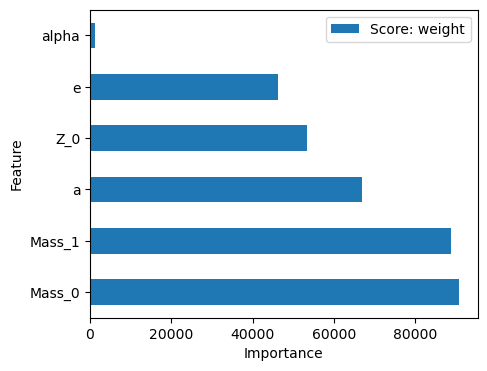

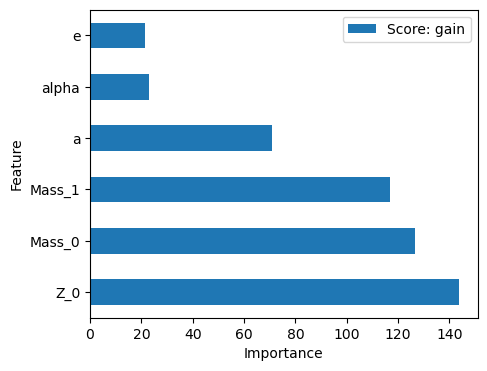

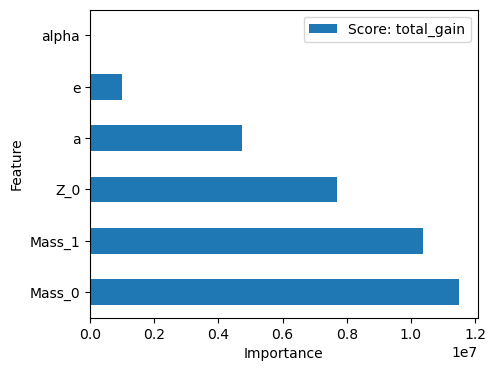

In [12]:
importances=['weight', 'gain', 'total_gain']
for im in importances:
    feature_important = bst.get_score(importance_type=im)
    keys = list(feature_important.keys())
    values = list(feature_important.values())

    data = pd.DataFrame(data=values, index=keys, columns=["Score: "+im]).sort_values(by = "Score: "+im, ascending=False)
    data.plot(kind='barh', figsize = (5,4)) ## plot top 40 features
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.savefig('../Figures/lcp/importance_Chirp_mass_nokicks'+im+'.png')

## Prediction on test

In [13]:
## distributions of the probability of each class for each record

output_test = xgb.dask.predict(client, bst, features_test).persist() #already a dataframe

## Predicition of the label with Maximum estimation

predicted_label = output_test.idxmax(axis=1).persist()

## Computing the true labels and the predicted

Y_test = label_test.values.compute()

Y_predicted = predicted_label.values.compute()

## Scatter Plot with density

In [14]:
def using_mpl_scatter_density(fig, x, y):
    ax = fig.add_subplot(1, 1, 1, projection='scatter_density')
    density = ax.scatter_density(x, y, cmap='Reds',
                                 norm=colors.LogNorm(vmin=1, vmax=1000)
                                )
    fig.colorbar(density, label='Number of points per pixel')

/home/ubuntu/miniconda3/lib/python3.10/site-packages/mpl_scatter_density/generic_density_artist.py:77: RuntimeWarning: All-NaN slice encountered
  vmin = self._density_vmin(array)
/home/ubuntu/miniconda3/lib/python3.10/site-packages/mpl_scatter_density/generic_density_artist.py:82: RuntimeWarning: All-NaN slice encountered
  vmax = self._density_vmax(array)


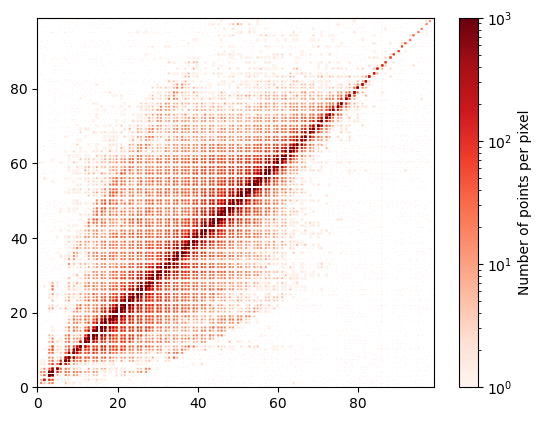

In [15]:
fig = plt.figure()
using_mpl_scatter_density(fig, Y_test, Y_predicted)
plt.show()

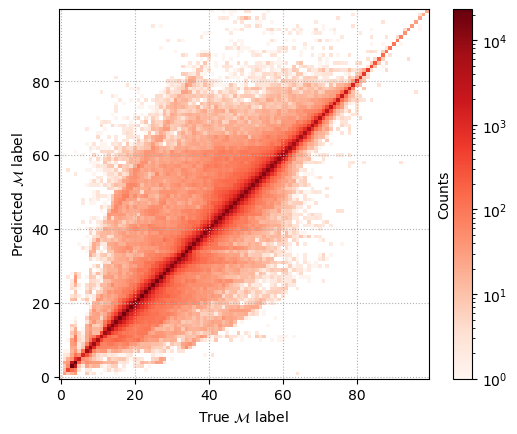

In [15]:
cm=confusion_matrix(Y_test, Y_predicted)
fig = plt.figure()
ax = fig.add_subplot(111)
pp=ax.matshow(cm.T, norm=colors.LogNorm(vmin=1, vmax=cm.max()), cmap='Reds', origin='lower')
cbar=fig.colorbar(pp)
cbar.ax.get_yaxis().labelpad = -50
cbar.ax.set_ylabel('Counts', rotation=90)
plt.grid(linestyle='dotted')
plt.gca().xaxis.tick_bottom()
plt.xlabel(r'True $\mathcal{M}$ label')
plt.ylabel(r'Predicted $\mathcal{M}$ label')
plt.savefig('../Figures/lcp/confusion_matrix_labels_Chirp_Mass_nokick.png', bbox_inches='tight')

## Histogram of the q distribution

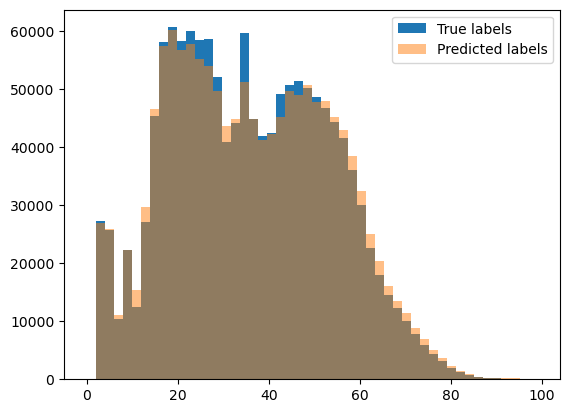

In [16]:
plt.hist(Y_test, bins=50, label = 'True labels')
plt.hist(Y_predicted, bins=50, alpha=0.5, label='Predicted labels')
plt.legend()

# Metrics

In [17]:
counts_test, _ = np.histogram(Y_test, density=True, bins=n_bins)
counts_predicted, _ = np.histogram(Y_predicted, density=True, bins=n_bins)

## Kulback-Leibler metrics

In [18]:
KL_div = scipy.stats.entropy(counts_predicted, counts_test)

In [19]:
KL_div

0.003054161596263368

## JS (limited between 0 and 1 when base=2)

In [20]:
JS_div = JS(counts_test, counts_predicted, base=2)

In [21]:
JS_div

0.03309570033239659

## Histogram of the Chirp mass distribution with metrics

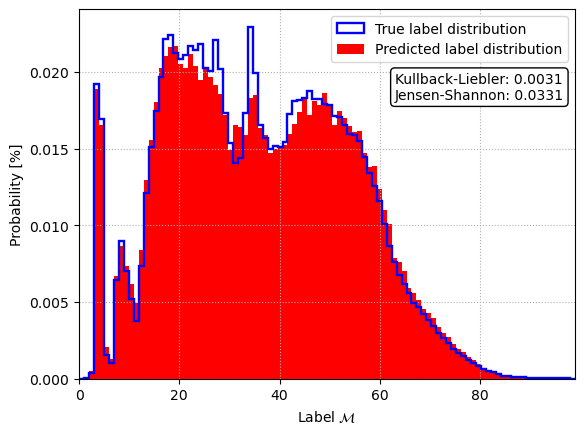

In [22]:
plt.hist(Y_test, bins=n_bins, label = 'True label distribution', histtype='step', density=True, color='blue',  linewidth=1.7)#, linestyle='dashed')
plt.hist(Y_predicted, bins=n_bins, label='Predicted label distribution', density=True, color='red')
plt.xlim(0,99)
plt.grid(linestyle='dotted')
plt.xlabel(r'Label $\mathcal{M}$')
plt.ylabel('Probability [%]')
plt.text(63, 0.020, "Kullback-Liebler: {:.4f}\nJensen-Shannon: {:.4f}".format(KL_div, JS_div),
         ha="left", va="top",
         bbox=dict(boxstyle="round",
                   ec='black',
                   fc='white',
                   )
         )
plt.legend()
plt.savefig('../Figures/lcp/hist_Chirp_Mass_nokicks.png', bbox_inches='tight')

## Histogram of difference of true and prediction

In [23]:
#95% interval 
diff = (Y_predicted-Y_test)
lower=np.quantile(diff, q=0.025) 
upper= np.quantile(diff, q=0.975)
print(lower, upper)

-5.0 10.0


Text(0.5, 0, '$|y_{true}-y_{predicted}|$')

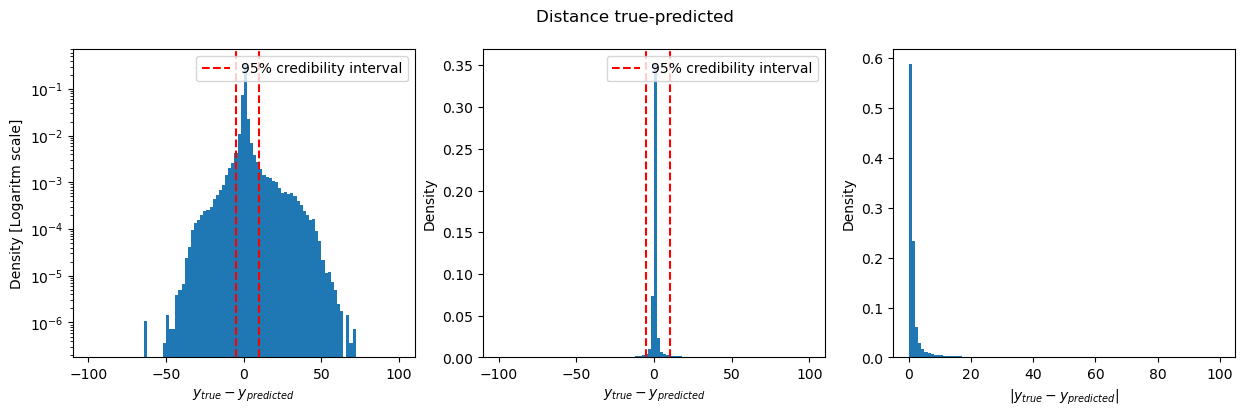

In [25]:
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15,4))

fig.suptitle('Distance true-predicted')
ax[0].hist(-Y_test+Y_predicted, bins=n_bins, density=True, log=True, range=(-n_bins, n_bins));
ax[0].axvline(lower,  label='95% credibility interval', color='red', linestyle='--');
ax[0].axvline(x=upper, color='red', linestyle='--');
ax[0].set_ylabel('Density [Logaritm scale]')
ax[0].set_xlabel(r'$y_{true}-y_{predicted}$')
ax[0].legend()

ax[1].hist(-Y_test+Y_predicted, bins=n_bins, density=True, range=(-n_bins, n_bins));
ax[1].axvline(x=lower, label='95% credibility interval', color='red', linestyle='--');
ax[1].axvline(x=upper, color='red', linestyle='--');
ax[1].set_ylabel('Density')
ax[1].set_xlabel(r'$y_{true}-y_{predicted}$')
ax[1].legend()

ax[2].hist(np.abs(-Y_test+Y_predicted), bins=n_bins, density=True, range=(0, n_bins));
ax[2].set_ylabel('Density')
ax[2].set_xlabel(r'$|y_{true}-y_{predicted}|$')

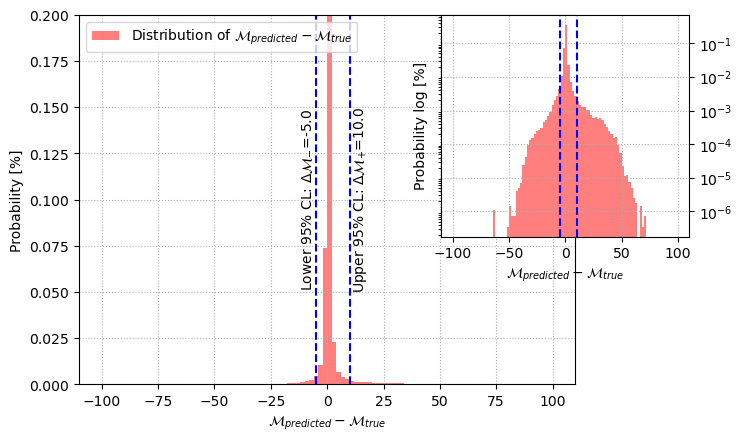

In [25]:
fig = plt.figure()
ax = fig.add_subplot(111)

# Create an inset outside the axes
axins = inset_axes(ax, width="100%", height="100%",
                   bbox_to_anchor=(.73, .4, .5, .6),
                   bbox_transform=ax.transAxes, loc=2, borderpad=0)
axins.tick_params(left=False, right=True, labelleft=False, labelright=True)


axins.grid(linestyle='dotted')
ax.grid(linestyle='dotted')
axins.hist(Y_predicted-Y_test, bins=n_bins, density=True, range=(-n_bins, n_bins),
           color='red', linewidth=1.7, log=True, histtype='stepfilled', alpha=0.5)
ax.hist(Y_predicted-Y_test, bins=n_bins, density=True, range=(-n_bins, n_bins),
         alpha=0.5, color='red', label=r'Distribution of $\mathcal{M} _{predicted}-\mathcal{M}_{true}$')
ax.legend(loc=2)
ax.set_ylabel("Probability [%]")
axins.set_ylabel("Probability log [%]")
ax.set_xlabel(r'$\mathcal{M}_{predicted}-\mathcal{M}_{true}$')
axins.set_xlabel(r'$\mathcal{M}_{predicted}-\mathcal{M}_{true}$')
ax.set_ylim(0,0.2)

ax.axvline(x=lower, label='95% credibility interval', color='blue', linestyle='--');
ax.axvline(x=upper, color='blue', linestyle='--');

axins.axvline(x=lower, label='95% credibility interval', color='blue', linestyle='--');
axins.axvline(x=upper, color='blue', linestyle='--');
ax.text(lower-7,0.1, r'Lower 95% CL: $\Delta \mathcal{M}_{-}$='+str(lower), rotation=90, va='center')
ax.text(upper+1,0.1, r'Upper 95% CL: $\Delta \mathcal{M}_{+}$='+str(upper), rotation=90, va='center')
plt.savefig('../Figures/lcp/hist_delta_Chirp_Mass_nokicks.png', bbox_inches='tight')
plt.show()

## Misura della accuracy

In [26]:
threshold = 4

In [27]:
## Defining a prediction accurate if not further from the true of a value of threshold
def accuracy_threshold(Y_test, Y_predicted, threshold = 5):
    out=np.abs(Y_test-Y_predicted)
    mask = out < threshold
    return np.sum(mask)/len(Y_test)

In [28]:
accuracy_threshold(Y_test, Y_predicted, 4)

0.9096120890438766

In [29]:
def accuracy_exponential(Y_test, Y_predicted, threshold = 25, tau = 25):
    out = np.exp(-np.abs(Y_test-Y_predicted)/tau)
    out = out[np.abs(Y_test-Y_predicted)<threshold]
    return np.sum(out)/len(Y_test)

In [30]:
accuracy_exponential(Y_test, Y_predicted)

0.9491800923994632

## Grid Search with For Loops

## Clustering of probability distribution

In [31]:
# Defininf a function to order the peaks of the probability distribution
def extract_top_values(row, n_top=3):
    row_sorted = np.sort(row)[::-1]
    return row_sorted[:n_top]

In [32]:
# Defininf a function to order the peaks of the probability distribution
def extract_id_top_values(row, n_top=3):
    idx_sorted = np.argsort(row)[::-1]
    return np.array(idx_sorted)[:n_top]

In [33]:
# applying the previous function
top_values = output_test.apply(extract_top_values, axis=1, meta=(None, 'object'))
idx_top_values = output_test.apply(extract_id_top_values, axis=1, meta=(None, 'object'))

## Creating a dataframe with all the test set information

In [34]:
top_values = top_values.compute()
top_values = pd.DataFrame(top_values.to_list(), columns = ['1', '2', '3'])

idx_top_values = idx_top_values.compute()
idx_top_values = pd.DataFrame(idx_top_values.to_list(), columns = ['1', '2', '3'])

for col in idx_top_values.columns:
    top_values[f'idx_{col}']=idx_top_values[col].values   
    
top_values['Y_predicted']=Y_predicted
top_values['Y_test']=Y_test
top_values['Delta_Y']=np.abs(Y_predicted-Y_test)

#adding feature
X_test = features_test.compute()
for col in X_test.columns:
    top_values[col]=X_test[col].values

In [35]:
top_values

1         2         3  idx_1  idx_2  idx_3  Y_predicted  \
0        0.197164  0.119886  0.040944     60     61     58           60   
1        0.115496  0.057462  0.040522     66     61     60           66   
2        0.111406  0.045357  0.041785     29     32     41           29   
3        0.070576  0.050466  0.039593     50     51     53           50   
4        0.372449  0.178897  0.113758     68     69     67           68   
...           ...       ...       ...    ...    ...    ...          ...   
1403977  0.072858  0.045059  0.044712     16     17     15           16   
1403978  0.637367  0.217555  0.008716     56     57     55           56   
1403979  0.438071  0.179609  0.012055     36     35     37           36   
1403980  0.236414  0.171189  0.121918     31     35     34           31   
1403981  0.968234  0.005740  0.001617     25     29     26           25   

         Y_test  Delta_Y   Mass_0     Z_0   Mass_1        a        e  alpha  
0          61.0      1.0  117.304  0.0004   83.859    490.0  0.01200    1.0  
1          60.0      6.0  103.967  0.0004   94.651  46600.0  0.10200    1.0  
2          24.0      5.0   57.596  0.0004   30.071    492.0  0.72200    1.0  
3          45.0      5.0   41.970  0.0004   39.797    149.0  0.04660    1.0  
4          68.0      0.0   64.356  0.0004   46.568   5080.0  0.01260    1.0  
...         ...      ...      ...     ...      ...      ...      ...    ...  
1403977    21.0      5.0   37.869  0.0100   31.319   2230.0  0.23600    3.0  
1403978    56.0      0.0  123.443  0.0100  120.154   9180.0  0.12400    3.0  
1403979    36.0      0.0   99.721  0.0100   34.657  16300.0  0.62100    3.0  
1403980    34.0      3.0   84.835  0.0100   53.354   1060.0  0.00132    3.0  
1403981    25.0      0.0   53.459  0.0100   38.886  45100.0  0.25500    3.0  

[1403982 rows x 15 columns]

In [37]:
idx_diff = top_values['idx_1']-top_values['idx_2']

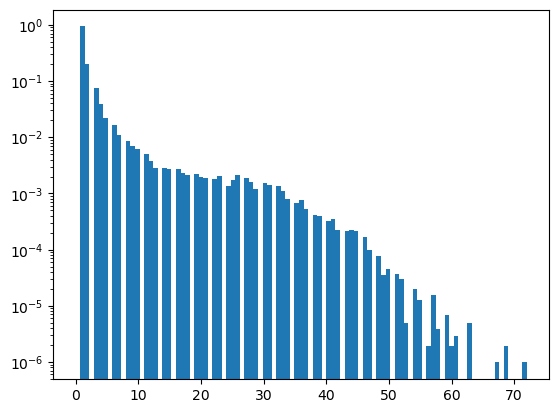

In [38]:
plt.hist(np.abs(idx_diff), bins=99, density=True, log=True, range=(0, idx_diff.max()));

# Some interesting representations

## All the points

/home/ubuntu/miniconda3/lib/python3.10/site-packages/mpl_scatter_density/generic_density_artist.py:77: RuntimeWarning: All-NaN slice encountered
  vmin = self._density_vmin(array)
/home/ubuntu/miniconda3/lib/python3.10/site-packages/mpl_scatter_density/generic_density_artist.py:82: RuntimeWarning: All-NaN slice encountered
  vmax = self._density_vmax(array)


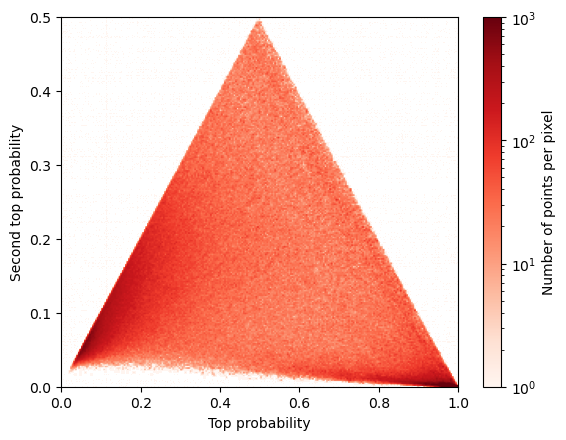

In [39]:
fig = plt.figure()
using_mpl_scatter_density(fig, top_values['1'], top_values['2'])
plt.xlabel('Top probability')
plt.ylabel('Second top probability')
plt.xlim(0,1)
plt.ylim(0,0.5)
plt.show()

/home/ubuntu/miniconda3/lib/python3.10/site-packages/mpl_scatter_density/generic_density_artist.py:77: RuntimeWarning: All-NaN slice encountered
  vmin = self._density_vmin(array)
/home/ubuntu/miniconda3/lib/python3.10/site-packages/mpl_scatter_density/generic_density_artist.py:82: RuntimeWarning: All-NaN slice encountered
  vmax = self._density_vmax(array)


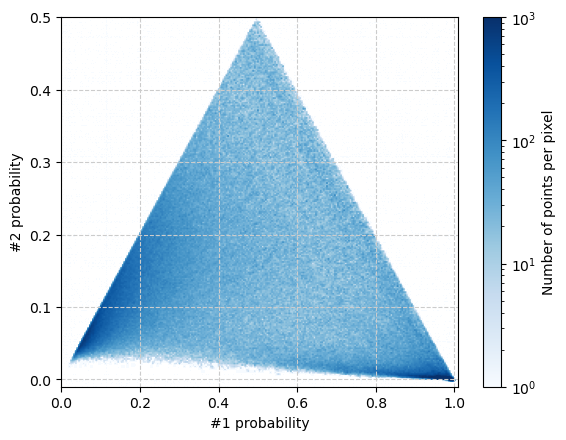

In [36]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection='scatter_density')
density = ax.scatter_density( top_values['1'], top_values['2'], cmap='Blues',
                             norm=colors.LogNorm(vmin=1, vmax=1000))
cbar=fig.colorbar(density, label='Number of points per pixel', location='right')
cbar.ax.get_xaxis().labelpad = -30
    
    
plt.xlabel('#1 probability')
plt.ylabel('#2 probability')
plt.xlim(0,1.01)
plt.ylim(-0.01,0.5)
# plt.axhline(0, linestyle='dashed', color=(0,0,0,0.5), linewidth=1)
# plt.axvline(1, linestyle='dashed', color=(0,0,0,0.5), linewidth=1)
# plt.axline((-1,-1),(1,1),linestyle='dashed', color=(0,0,0,0.5), linewidth=1)
plt.grid(linestyle='dashed',color=(0.8,0.8,0.8,0.2) )

plt.savefig('../Figures/lcp/tops_Chirp_Mass_nokicks.png', bbox_inches='tight')
plt.show()

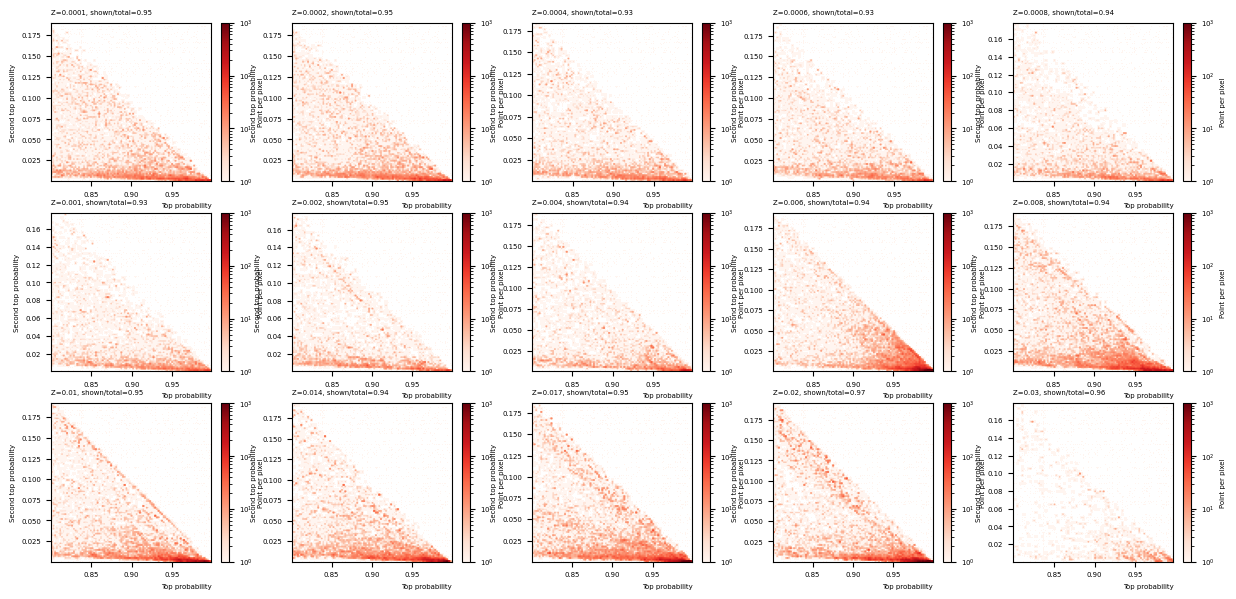

In [40]:
fontsize=5
fig = plt.figure(figsize=(15, 7))
Z=np.unique(top_values.Z_0)
for i, z in enumerate(Z):
    ax = fig.add_subplot(3, 5, i+1, projection='scatter_density')
    density = ax.scatter_density(x= top_values[(top_values.Z_0==z) & (top_values.Delta_Y == 0) & (top_values['1']>=0.8)]['1'],
                       y=top_values[(top_values.Z_0==z) & (top_values.Delta_Y == 0) & (top_values['1']>=0.8)]['2'],
                       cmap='Reds',
                       norm=colors.LogNorm(vmin=1, vmax=1000))
    ax.set_xlabel('Top probability', fontsize=fontsize, loc='right')
    ax.tick_params(labelsize=fontsize)
    ax.set_ylabel('Second top probability', fontsize=fontsize)
    # ax.set_xlim(0,1)
    # ax.set_ylim(0,0.5)
    
    
    cbar = fig.colorbar(density, ax=ax)
    cbar.ax.set_ylabel(ylabel='Point per pixel', fontsize=fontsize)
    cbar.ax.tick_params(labelsize=fontsize)
    # cbar.set_label(fontsize=fontsize, label='Number of points per pixel')
    
    ax.set_title(f'Z={z}, shown/total={len(top_values[(top_values.Z_0==z) & (top_values.Delta_Y == 0) & (top_values["1"]>=0.8)])/len(top_values[(top_values.Z_0==z) & (top_values["1"]>=0.8)]):.2f}',
                 fontsize=fontsize,
                 loc='left')
    
# sns.scatterplot(data = top_values, x= '1', y='2', hue='Z_0', size=0.001)

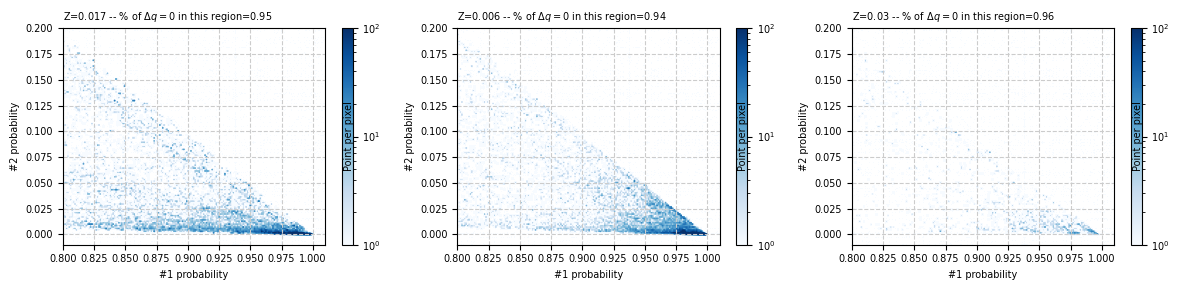

In [37]:
fontsize=7
fig = plt.figure(figsize=(12, 3))
Z=np.unique(top_values.Z_0)
Z=[0.017, 0.006, 0.03]

for i, z in enumerate(Z):
    ax = fig.add_subplot(1, 3, i+1, projection='scatter_density',)
    density = ax.scatter_density(x= top_values[(top_values.Z_0==z) & (top_values.Delta_Y == 0) & (top_values['1']>=0.8)]['1'],
                       y=top_values[(top_values.Z_0==z) & (top_values.Delta_Y == 0) & (top_values['1']>=0.8)]['2'],
                       cmap='Blues',
                       norm=colors.LogNorm(vmin=1, vmax=100), )
    ax.set_xlabel('#1 probability', fontsize=fontsize,)
    ax.tick_params(labelsize=fontsize)
    ax.set_ylabel('#2 probability', fontsize=fontsize)
    ax.set_xlim(0.8,1.01)
    ax.set_ylim(-0.01,0.2)
    ax.grid(linestyle='dashed', color=(0.8,0.8,0.8,0.2))
    
    # if i==2:
    cbar = fig.colorbar(density, ax=ax)
    cbar.ax.set_ylabel(ylabel='Point per pixel', fontsize=fontsize)
    cbar.ax.tick_params(labelsize=fontsize)
    cbar.ax.get_yaxis().labelpad = -26.5
    # cbar.set_label(fontsize=fontsize, label='Number of points per pixel')
    
    ax.set_title(rf'Z={z} -- % of $\Delta q=0$ in this region={len(top_values[(top_values.Z_0==z) & (top_values.Delta_Y == 0) & (top_values["1"]>=0.8)])/len(top_values[(top_values.Z_0==z) & (top_values["1"]>=0.8)]):.2f}',
                 fontsize=fontsize,
                 loc='left')
plt.tight_layout()
plt.savefig('../Figures/lcp/zoom_peakregion_Chirp_Mass_nokicks.png', bbox_inches='tight')

## Point correctly predicted

In [39]:
top_values_0 = top_values[top_values['Delta_Y']==0]

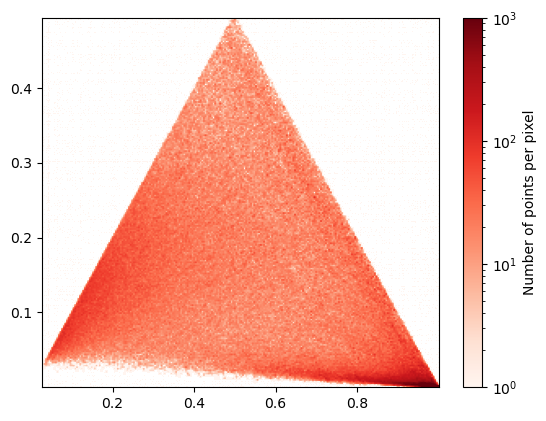

In [42]:
fig = plt.figure()
using_mpl_scatter_density(fig, top_values_0['1'], top_values_0['2'])
plt.show()

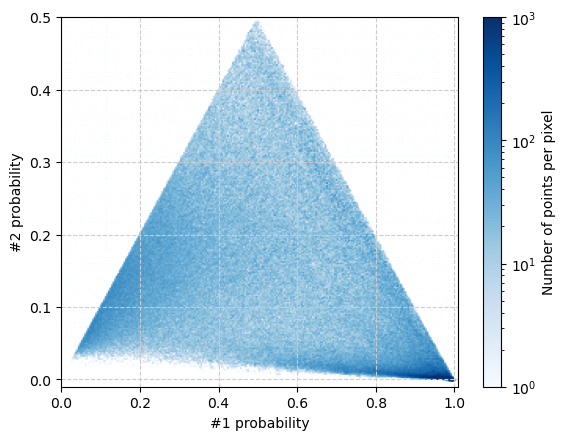

In [40]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection='scatter_density')
density = ax.scatter_density( top_values_0['1'], top_values_0['2'], cmap='Blues',
                             norm=colors.LogNorm(vmin=1, vmax=1000))
cbar=fig.colorbar(density, label='Number of points per pixel', location='right')
cbar.ax.get_xaxis().labelpad = -30
    
    
plt.xlabel('#1 probability')
plt.ylabel('#2 probability')
plt.xlim(0,1.01)
plt.ylim(-0.01,0.5)
# plt.axhline(0, linestyle='dashed', color=(0,0,0,0.5), linewidth=1)
# plt.axvline(1, linestyle='dashed', color=(0,0,0,0.5), linewidth=1)
# plt.axline((-1,-1),(1,1),linestyle='dashed', color=(0,0,0,0.5), linewidth=1)
plt.grid(linestyle='dashed',color=(0.8,0.8,0.8,0.2) )

plt.savefig('../Figures/lcp/tops_Mass_Chirp_perfect_nokicks.png', bbox_inches='tight')
plt.show()

### Check for the Mass dependency

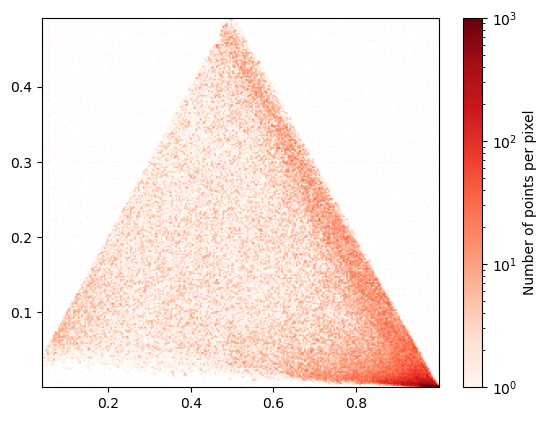

In [43]:
fig = plt.figure()
using_mpl_scatter_density(fig,
                          top_values_0[top_values_0['Mass_0']<40]['1'],
                          top_values_0[top_values_0['Mass_0']<40]['2'])
plt.show()

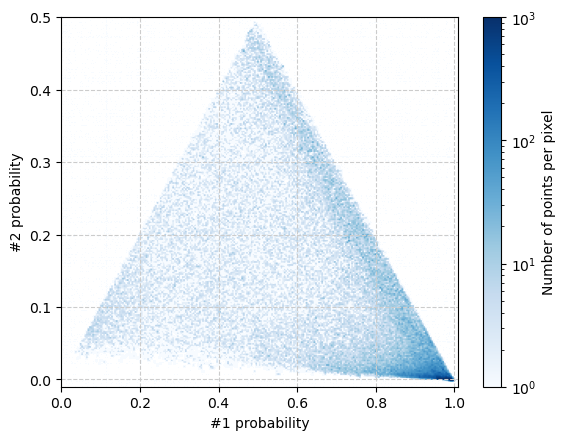

In [41]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection='scatter_density')
density = ax.scatter_density( top_values_0[top_values_0['Mass_0']<40]['1'], top_values_0[top_values_0['Mass_0']<40]['2'], cmap='Blues',
                             norm=colors.LogNorm(vmin=1, vmax=1000))
cbar=fig.colorbar(density, label='Number of points per pixel', location='right')
cbar.ax.get_xaxis().labelpad = -30
    
    
plt.xlabel('#1 probability')
plt.ylabel('#2 probability')
plt.xlim(0,1.01)
plt.ylim(-0.01,0.5)
# plt.axhline(0, linestyle='dashed', color=(0,0,0,0.5), linewidth=1)
# plt.axvline(1, linestyle='dashed', color=(0,0,0,0.5), linewidth=1)
# plt.axline((-1,-1),(1,1),linestyle='dashed', color=(0,0,0,0.5), linewidth=1)
plt.grid(linestyle='dashed',color=(0.8,0.8,0.8,0.2) )

plt.savefig('../Figures/lcp/tops_Chirp_Mass_perfect_mass_less_40_nokicks.png', bbox_inches='tight')
plt.show()

## Points with wrong prediction

In [42]:
top_values_15 = top_values[top_values['Delta_Y']>=threshold]

<Axes: xlabel='1', ylabel='2'>

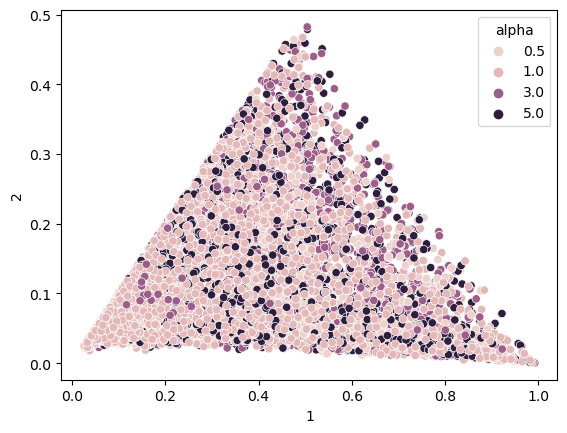

In [45]:
sns.scatterplot(data = top_values_15, x= '1', y='2', hue='alpha', )


/home/ubuntu/miniconda3/lib/python3.10/site-packages/mpl_scatter_density/generic_density_artist.py:77: RuntimeWarning: All-NaN slice encountered
  vmin = self._density_vmin(array)
/home/ubuntu/miniconda3/lib/python3.10/site-packages/mpl_scatter_density/generic_density_artist.py:82: RuntimeWarning: All-NaN slice encountered
  vmax = self._density_vmax(array)


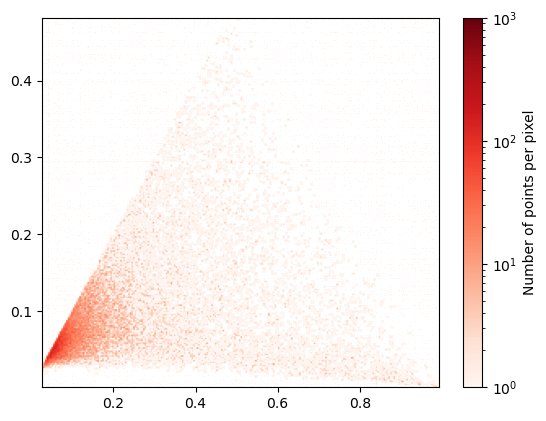

In [46]:
fig = plt.figure()
using_mpl_scatter_density(fig, top_values_15['1'], top_values_15['2'])
plt.show()

/home/ubuntu/miniconda3/lib/python3.10/site-packages/mpl_scatter_density/generic_density_artist.py:77: RuntimeWarning: All-NaN slice encountered
  vmin = self._density_vmin(array)
/home/ubuntu/miniconda3/lib/python3.10/site-packages/mpl_scatter_density/generic_density_artist.py:82: RuntimeWarning: All-NaN slice encountered
  vmax = self._density_vmax(array)


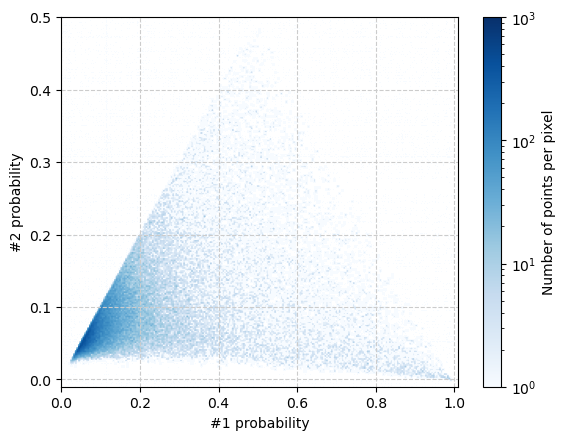

In [43]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection='scatter_density')
density = ax.scatter_density( top_values_15['1'], top_values_15['2'], cmap='Blues',
                             norm=colors.LogNorm(vmin=1, vmax=1000))
cbar=fig.colorbar(density, label='Number of points per pixel', location='right')
cbar.ax.get_xaxis().labelpad = -30
    
    
plt.xlabel('#1 probability')
plt.ylabel('#2 probability')
plt.xlim(0,1.01)
plt.ylim(-0.01,0.5)
# plt.axhline(0, linestyle='dashed', color=(0,0,0,0.5), linewidth=1)
# plt.axvline(1, linestyle='dashed', color=(0,0,0,0.5), linewidth=1)
# plt.axline((-1,-1),(1,1),linestyle='dashed', color=(0,0,0,0.5), linewidth=1)
plt.grid(linestyle='dashed',color=(0.8,0.8,0.8,0.2) )

plt.savefig(f'../Figures/lcp/tops_Chirp_Mass_error_more_{threshold}_nokicks.png', bbox_inches='tight')
plt.show()

### Searching for descrepancies in other features

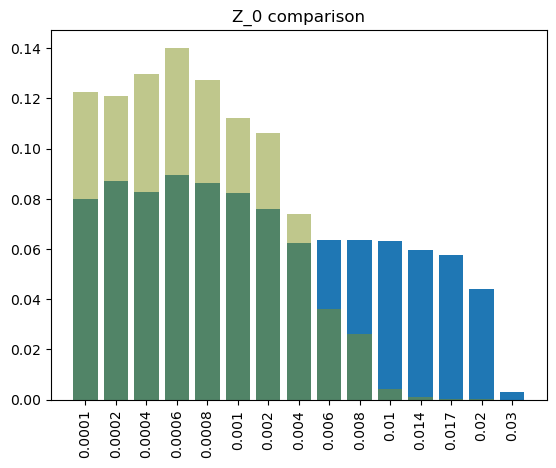

In [47]:
labels, counts = np.unique(top_values['Z_0'].values, return_counts=True)
plt.bar( labels.astype(str), counts/counts.sum())
plt.xticks(rotation=90);

labels, counts = np.unique(top_values_15['Z_0'].values, return_counts=True)
plt.bar( labels.astype(str), counts/counts.sum(), alpha=0.3)
plt.xticks(rotation=90);
plt.title('Z_0 comparison');

labels, counts = np.unique(top_values_15['Z_0'].values, return_counts=True)
plt.bar( labels.astype(str), counts/counts.sum(), alpha=0.3)
plt.xticks(rotation=90);
plt.title('Z_0 comparison');

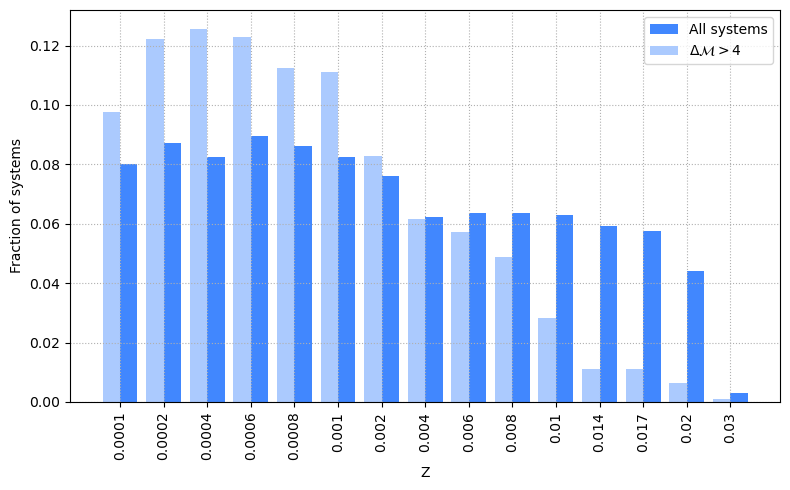

In [45]:
plt.figure(figsize=(8,5))
labels, counts_all = np.unique(top_values['Z_0'].values, return_counts=True)
X_axis = np.arange(len(labels))
plt.grid(linestyle='dotted')

plt.bar( X_axis+0.2, counts_all/counts_all.sum(),0.4,color=(65/255, 135/255, 254/255),label= 'All systems')
plt.xticks(rotation=90);

labels, counts = np.unique(top_values_15['Z_0'].values, return_counts=True)
plt.xticks(X_axis, labels)

plt.bar( X_axis-0.2, counts/counts.sum(),0.4,color=(171/255, 202/255, 254/255), label=r'$\Delta \mathcal{M}>4$')
plt.xticks(rotation=90);
# plt.title('Metalliomparison');
plt.legend()
plt.xlabel('Z')
plt.ylabel('Fraction of systems')
plt.tight_layout()
plt.savefig('../Figures/lcp/z_comparison_Chirp_Mass_nokicks.png', bbox_inches='tight')
plt.show()


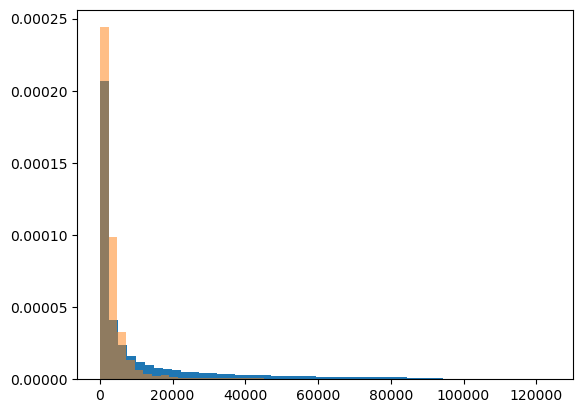

In [48]:
plt.hist(top_values['a'], density=True, bins=50);
plt.hist(top_values_15['a'], density=True, bins=50, alpha=0.5);

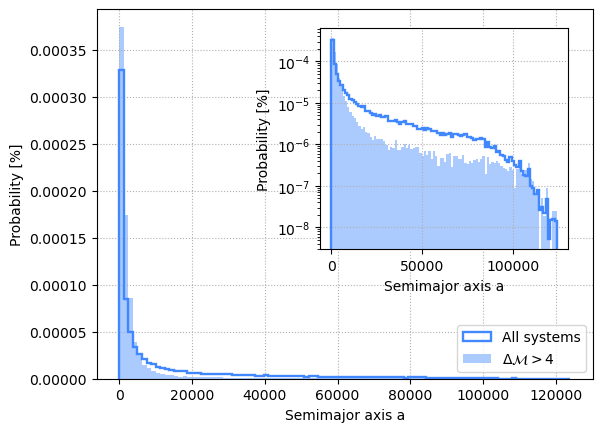

In [46]:
fig = plt.figure()
ax = fig.add_subplot(111)

# Create an inset outside the axes
axins = inset_axes(ax, width="100%", height="100%",
                   bbox_to_anchor=(.45, .35, .5, .6),
                   bbox_transform=ax.transAxes, loc=2, borderpad=0)
axins.tick_params( labelleft=True, labelright=False)


axins.grid(linestyle='dotted')
ax.grid(linestyle='dotted')


ax.hist(top_values['a'], bins=n_bins, label = 'All systems', histtype='step', density=True, color=(65/255, 135/255, 254/255),  linewidth=1.7)
ax.hist(top_values_15['a'], bins=n_bins, label=r'$\Delta \mathcal{M}>4}$', density=True, color=(171/255, 202/255, 254/255))

axins.hist(top_values['a'], bins=n_bins,log=True, histtype='step', density=True, color=(65/255, 135/255, 254/255),  linewidth=1.7)
axins.hist(top_values_15['a'], bins=n_bins, log=True, density=True, color=(171/255, 202/255, 254/255))

ax.legend(loc=4)

ax.set_ylabel("Probability [%]")
ax.set_xlabel('Semimajor axis a')

axins.set_ylabel("Probability [%]")
axins.set_xlabel('Semimajor axis a')

plt.savefig('../Figures/lcp/a_comparison_Mass_Chirp_nokicks.png', bbox_inches='tight')
plt.show()


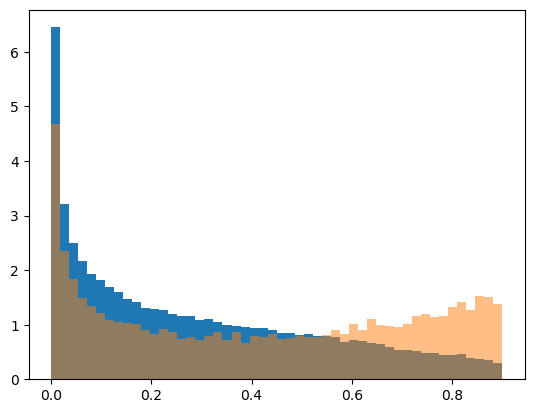

In [49]:
plt.hist(top_values['e'], density=True, bins=50, );
plt.hist(top_values_15['e'], density=True, bins=50, alpha=0.5);

/tmp/ipykernel_4320/2267823822.py:30: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


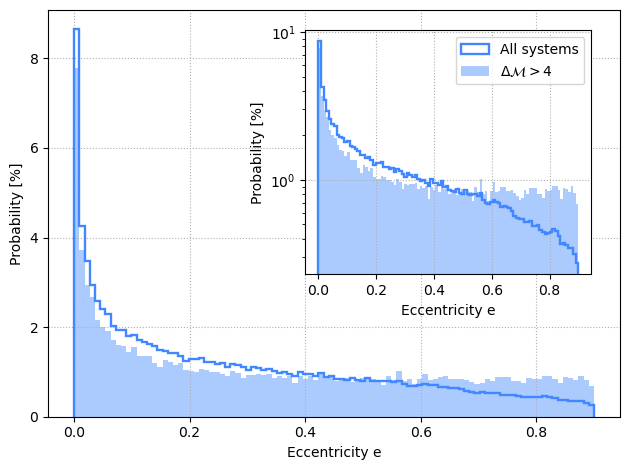

In [47]:
fig = plt.figure()
ax = fig.add_subplot(111)
# ax.legend(loc=5)

# Create an inset outside the axes
axins = inset_axes(ax, width="100%", height="100%",
                   bbox_to_anchor=(.45, .35, .5, .6),
                   bbox_transform=ax.transAxes, loc=2, borderpad=0)
axins.tick_params( labelleft=True, labelright=False)


axins.grid(linestyle='dotted')
ax.grid(linestyle='dotted')


ax.hist(top_values['e'], bins=n_bins, label = 'All systems', histtype='step', density=True, color=(65/255, 135/255, 254/255),  linewidth=1.7)
ax.hist(top_values_15['e'], bins=n_bins, label=r'$\Delta \mathcal{M}>4$', density=True, color=(171/255, 202/255, 254/255))

axins.hist(top_values['e'], bins=n_bins,log=True, label = 'All systems', histtype='step', density=True, color=(65/255, 135/255, 254/255),  linewidth=1.7)
axins.hist(top_values_15['e'], bins=n_bins, log=True, density=True,label=r'$\Delta \mathcal{M}>4$', color=(171/255, 202/255, 254/255))


ax.set_ylabel("Probability [%]")
ax.set_xlabel('Eccentricity e')

axins.set_ylabel("Probability [%]")
axins.set_xlabel('Eccentricity e')
l=axins.legend()
# l.set_zorder(10) 
plt.tight_layout()
plt.savefig('../Figures/lcp/e_comparison_Chirp_Mass_nokicks.png', bbox_inches='tight')
plt.show()


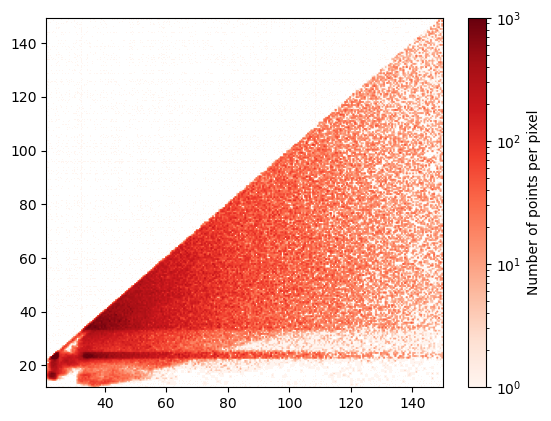

In [50]:
fig = plt.figure()
using_mpl_scatter_density(fig, top_values['Mass_0'], top_values['Mass_1'])
plt.show()

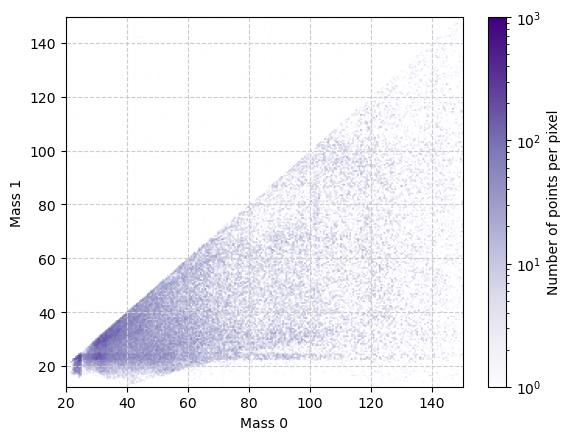

In [55]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection='scatter_density')
density = ax.scatter_density( top_values_15['Mass_0'], top_values_15['Mass_1'], cmap='Purples',
                             norm=colors.LogNorm(vmin=1, vmax=1000))
cbar=fig.colorbar(density, label='Number of points per pixel', location='right')
cbar.ax.get_xaxis().labelpad = -30
    
    
plt.xlabel('Mass 0')
plt.ylabel('Mass 1')
plt.xlim(20,150)
# plt.ylim(-0.01,0.5)
# plt.axhline(0, linestyle='dashed', color=(0,0,0,0.5), linewidth=1)
# plt.axvline(1, linestyle='dashed', color=(0,0,0,0.5), linewidth=1)
# plt.axline((-1,-1),(1,1),linestyle='dashed', color=(0,0,0,0.5), linewidth=1)
plt.grid(linestyle='dashed',color=(0.8,0.8,0.8,0.2) )

plt.savefig('../Figures/lcp/mass_0_mass_1_error_5_Chirp_mass_yeskicks.png')
plt.show()

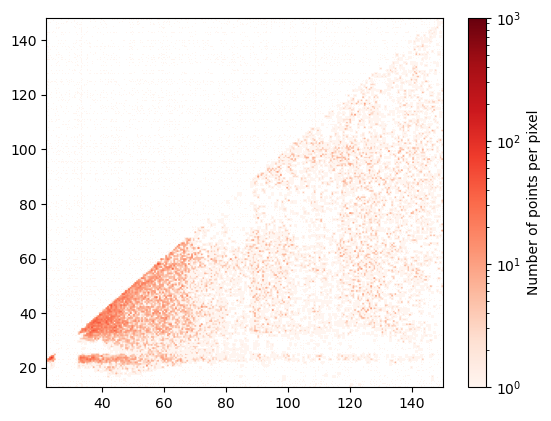

In [51]:
fig = plt.figure()
using_mpl_scatter_density(fig, top_values_15['Mass_0'], top_values_15['Mass_1'])
plt.show()

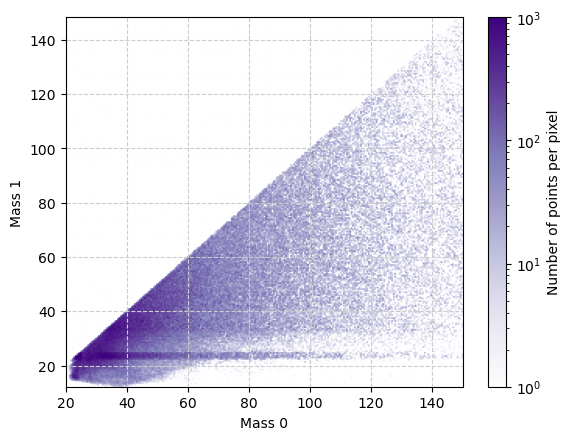

In [56]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection='scatter_density')
density = ax.scatter_density( top_values_0['Mass_0'], top_values_0['Mass_1'], cmap='Purples',
                             norm=colors.LogNorm(vmin=1, vmax=1000))
cbar=fig.colorbar(density, label='Number of points per pixel', location='right')
cbar.ax.get_xaxis().labelpad = -30
    
    
plt.xlabel('Mass 0')
plt.ylabel('Mass 1')
plt.xlim(20,150)
# plt.ylim(-0.01,0.5)
# plt.axhline(0, linestyle='dashed', color=(0,0,0,0.5), linewidth=1)
# plt.axvline(1, linestyle='dashed', color=(0,0,0,0.5), linewidth=1)
# plt.axline((-1,-1),(1,1),linestyle='dashed', color=(0,0,0,0.5), linewidth=1)
plt.grid(linestyle='dashed',color=(0.8,0.8,0.8,0.2) )

plt.savefig('../Figures/lcp/mass_0_mass_1_all_right_Chirp_Mass_yeskicks.png')
plt.show()

/home/ubuntu/miniconda3/lib/python3.10/site-packages/mpl_scatter_density/generic_density_artist.py:77: RuntimeWarning: All-NaN slice encountered
  vmin = self._density_vmin(array)
/home/ubuntu/miniconda3/lib/python3.10/site-packages/mpl_scatter_density/generic_density_artist.py:82: RuntimeWarning: All-NaN slice encountered
  vmax = self._density_vmax(array)


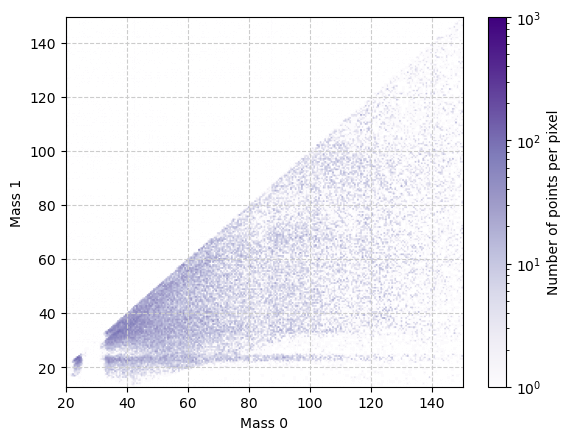

In [48]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection='scatter_density')
density = ax.scatter_density( top_values_15['Mass_0'], top_values_15['Mass_1'], cmap='Purples',
                             norm=colors.LogNorm(vmin=1, vmax=1000))
cbar=fig.colorbar(density, label='Number of points per pixel', location='right')
cbar.ax.get_xaxis().labelpad = -30
    
    
plt.xlabel('Mass 0')
plt.ylabel('Mass 1')
plt.xlim(20,150)
# plt.ylim(-0.01,0.5)
# plt.axhline(0, linestyle='dashed', color=(0,0,0,0.5), linewidth=1)
# plt.axvline(1, linestyle='dashed', color=(0,0,0,0.5), linewidth=1)
# plt.axline((-1,-1),(1,1),linestyle='dashed', color=(0,0,0,0.5), linewidth=1)
plt.grid(linestyle='dashed',color=(0.8,0.8,0.8,0.2) )

plt.savefig('../Figures/lcp/mass_0_mass_1_error_4_Chirp_mass_nokicks.png', bbox_inches='tight')
plt.show()

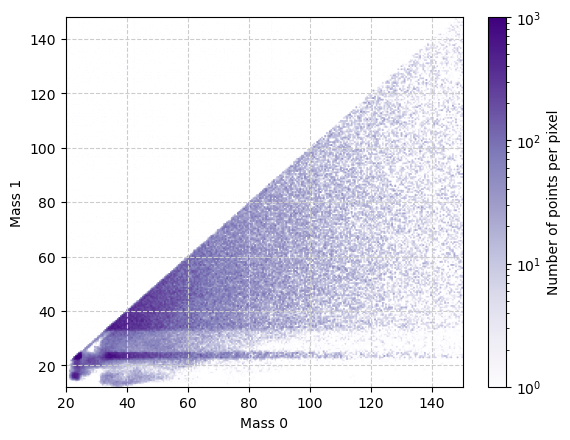

In [49]:
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1, projection='scatter_density')
density = ax.scatter_density( top_values_0['Mass_0'], top_values_0['Mass_1'], cmap='Purples',
                             norm=colors.LogNorm(vmin=1, vmax=1000))
cbar=fig.colorbar(density, label='Number of points per pixel', location='right')
cbar.ax.get_xaxis().labelpad = -30
    
    
plt.xlabel('Mass 0')
plt.ylabel('Mass 1')
plt.xlim(20,150)
# plt.ylim(-0.01,0.5)
# plt.axhline(0, linestyle='dashed', color=(0,0,0,0.5), linewidth=1)
# plt.axvline(1, linestyle='dashed', color=(0,0,0,0.5), linewidth=1)
# plt.axline((-1,-1),(1,1),linestyle='dashed', color=(0,0,0,0.5), linewidth=1)
plt.grid(linestyle='dashed',color=(0.8,0.8,0.8,0.2) )

plt.savefig('../Figures/lcp/mass_0_mass_1_all_right_Chirp_Mass_nokicks.png', bbox_inches='tight')
plt.show()

(14.559450000000002, 156.44955)

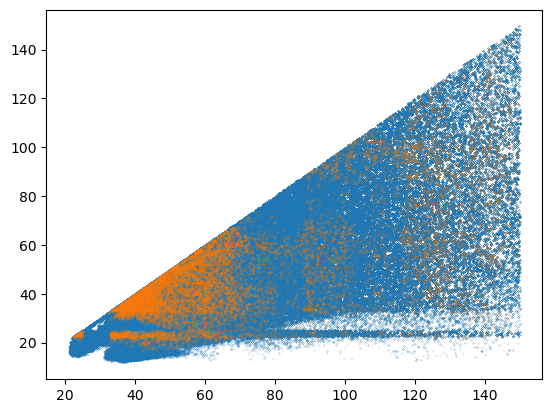

In [52]:
plt.scatter(top_values['Mass_0'], top_values['Mass_1'], s=0.01)
plt.scatter(top_values_15['Mass_0'], top_values_15['Mass_1'], alpha=0.9, s=0.01)
plt.xlim()

## Attempt of 3D plot

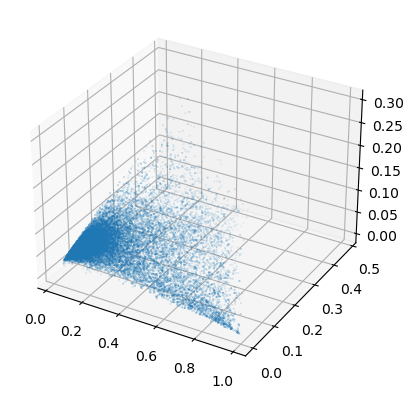

In [53]:
fig=plt.figure()
ax=plt.axes(projection='3d')
ax.scatter3D(top_values_15['1'], top_values_15['2'], top_values_15['3'], s=0.01)

## Some simple statistics

In [50]:
print(f'Fraction of data in the flat region: {len(top_values[top_values["1"]<0.2])/len(top_values):.2f}')

print(f'Fraction of exactly guessed labels: {len(top_values_0)/len(top_values):.2f}')

print( f"Exactly guessed label in flat region / total points in flat region:{  len(top_values_0[top_values_0['1']<0.2])/len(top_values[top_values['1']<0.2])  :.2f}"   )

print( f"Exactly guessed label in flat region / total exactly labels:{  len(  top_values_0[ top_values_0[ '1' ]<0.2 ] )/len(top_values_0)  :.2f}"   )



# len(top_values[top_values['1']<0.2])/len(top_values)

Fraction of data in the flat region: 0.23
Fraction of exactly guessed labels: 0.59
Exactly guessed label in flat region / total points in flat region:0.25
Exactly guessed label in flat region / total exactly labels:0.10


In [55]:
# cluster.close()

# Clustering by eye

# Plot of cluster

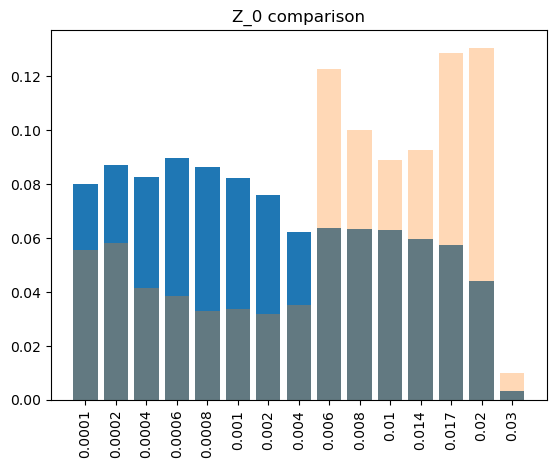

In [57]:
labels, counts = np.unique(top_values['Z_0'].values, return_counts=True)
plt.bar( labels.astype(str), counts/counts.sum())
plt.xticks(rotation=90);

labels, counts = np.unique(top_values[top_values.Cluster_peak==1]['Z_0'].values, return_counts=True)
plt.bar( labels.astype(str), counts/counts.sum(), alpha=0.3)
plt.xticks(rotation=90);
plt.title('Z_0 comparison');


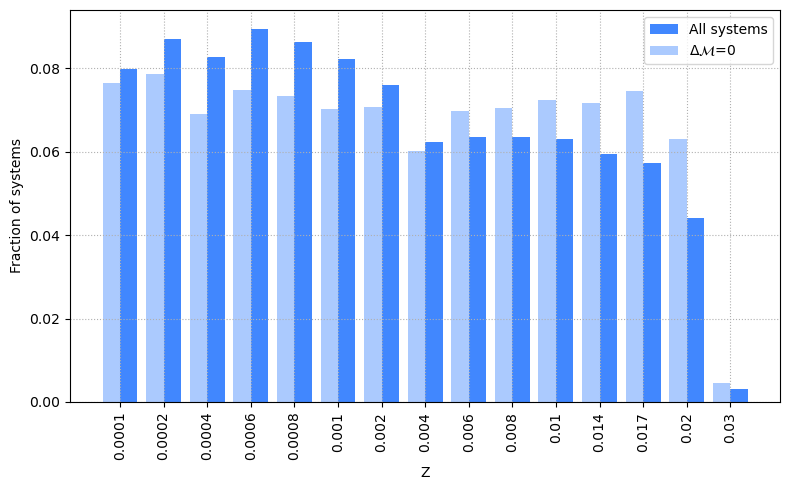

In [51]:
plt.figure(figsize=(8,5))
labels, counts_all = np.unique(top_values['Z_0'].values, return_counts=True)
X_axis = np.arange(len(labels))
plt.grid(linestyle='dotted')

plt.bar( X_axis+0.2, counts_all/counts_all.sum(),0.4,color=(65/255, 135/255, 254/255),label= 'All systems')
plt.xticks(rotation=90);

labels, counts = np.unique(top_values_0['Z_0'].values, return_counts=True)
plt.xticks(X_axis, labels)

plt.bar( X_axis-0.2, counts/counts.sum(),0.4,color=(171/255, 202/255, 254/255), label=r'$\Delta \mathcal{M}$=0')
plt.xticks(rotation=90);
# plt.title('Metalliomparison');
plt.legend()
plt.xlabel('Z')
plt.ylabel('Fraction of systems')
plt.tight_layout()
plt.savefig('../Figures/lcp/z_comparison_Mass_Chirp_one_peak_nokicks.png', bbox_inches='tight')
plt.show()


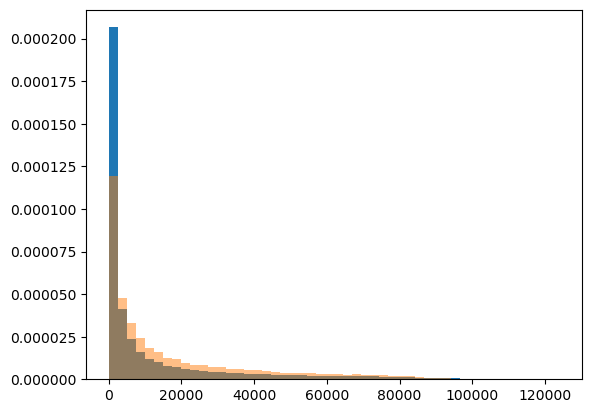

In [58]:
plt.hist(top_values['a'], density=True, bins=50);
plt.hist(top_values[top_values.Cluster_peak==1]['a'], density=True, bins=50, alpha=0.5);

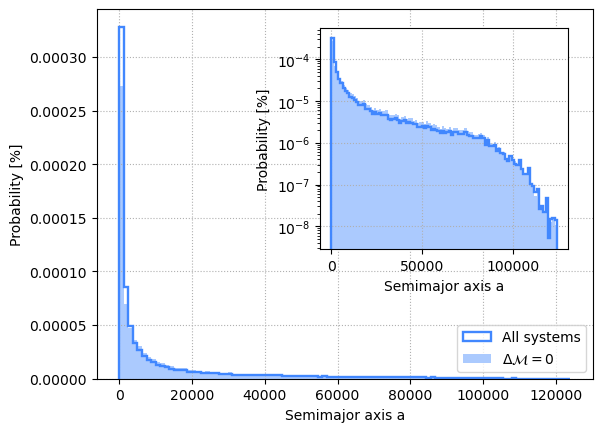

In [52]:
fig = plt.figure()
ax = fig.add_subplot(111)

# Create an inset outside the axes
axins = inset_axes(ax, width="100%", height="100%",
                   bbox_to_anchor=(.45, .35, .5, .6),
                   bbox_transform=ax.transAxes, loc=2, borderpad=0)
axins.tick_params( labelleft=True, labelright=False)


axins.grid(linestyle='dotted')
ax.grid(linestyle='dotted')


ax.hist(top_values['a'], bins=n_bins, label = 'All systems', histtype='step', density=True, color=(65/255, 135/255, 254/255),  linewidth=1.7)
ax.hist(top_values_0['a'], bins=n_bins, label=r'$\Delta \mathcal{M}=0$', density=True, color=(171/255, 202/255, 254/255))

axins.hist(top_values['a'], bins=n_bins,log=True, histtype='step', density=True, color=(65/255, 135/255, 254/255),  linewidth=1.7)
axins.hist(top_values_0['a'], bins=n_bins, log=True, density=True, color=(171/255, 202/255, 254/255))

ax.legend(loc=4)

ax.set_ylabel("Probability [%]")
ax.set_xlabel('Semimajor axis a')

axins.set_ylabel("Probability [%]")
axins.set_xlabel('Semimajor axis a')

plt.savefig('../Figures/lcp/a_comparison_Mass_Chirp_one_peak_nokicks.png', bbox_inches='tight')
plt.show()


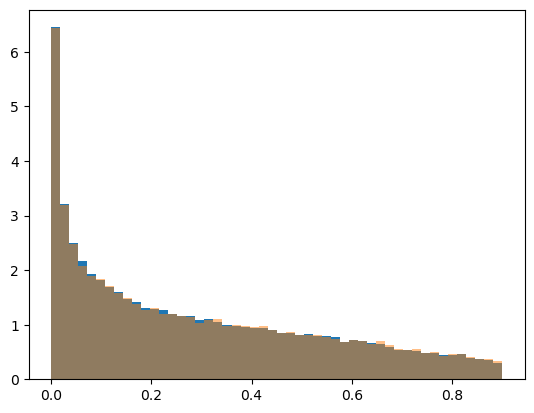

In [59]:
plt.hist(top_values['e'], density=True, bins=50, );
plt.hist(top_values[top_values.Cluster_peak==1]['e'], density=True, bins=50, alpha=0.5);

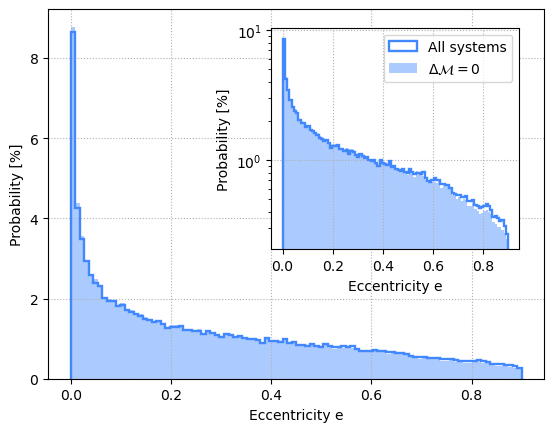

In [53]:
fig = plt.figure()
ax = fig.add_subplot(111)
# ax.legend(loc=5)

# Create an inset outside the axes
axins = inset_axes(ax, width="100%", height="100%",
                   bbox_to_anchor=(.45, .35, .5, .6),
                   bbox_transform=ax.transAxes, loc=2, borderpad=0)
axins.tick_params( labelleft=True, labelright=False)


axins.grid(linestyle='dotted')
ax.grid(linestyle='dotted')


ax.hist(top_values['e'], bins=n_bins, label = 'All systems', histtype='step', density=True, color=(65/255, 135/255, 254/255),  linewidth=1.7)
ax.hist(top_values_0['e'], bins=n_bins, label=r'$\Delta \mathcal{M}=0$', density=True, color=(171/255, 202/255, 254/255))

axins.hist(top_values['e'], bins=n_bins,log=True, label = 'All systems', histtype='step', density=True, color=(65/255, 135/255, 254/255),  linewidth=1.7)
axins.hist(top_values_0['e'], bins=n_bins, log=True, density=True,label=r'$\Delta \mathcal{M}=0$', color=(171/255, 202/255, 254/255))


ax.set_ylabel("Probability [%]")
ax.set_xlabel('Eccentricity e')

axins.set_ylabel("Probability [%]")
axins.set_xlabel('Eccentricity e')
l=axins.legend()
# l.set_zorder(10) 
plt.savefig('../Figures/lcp/e_comparison_Mass_Chirp_one_peak_nokicks.png', bbox_inches='tight')
plt.show()


In [60]:
bhbh_test.columns

Index(['name', 'Mass_0', 'Z_0', 'SN_0', 'Mass_1', 'SN_1', 'a', 'e', 'alpha',
       'Mass_0_out', 'Mass_1_out', 'Semimajor', 'Eccentricity', 'GWtime',
       'BWorldtime', 'RLO', 'CE', 'BSN', 'No_Kick', 'tdelay', 'Mass_max_out',
       'q', 'Mass_chirp', 'Mass_chirp_norm', 'label'],
      dtype='object')

In [61]:
bhbh_test[bhbh_test.Z_0==0.006].groupby("No_Kick").count().compute()

name  Mass_0    Z_0   SN_0  Mass_1   SN_1      a      e  alpha  \
No_Kick                                                                    
2.0      89274   89274  89274  89274   89274  89274  89274  89274  89274   

         Mass_0_out  ...  BWorldtime    RLO     CE    BSN  tdelay  \
No_Kick              ...                                            
2.0           89274  ...       89274  89274  89274  89274   89274   

         Mass_max_out      q  Mass_chirp  Mass_chirp_norm  label  
No_Kick                                                           
2.0             89274  89274       89274            89274  89274  

[1 rows x 24 columns]